In [76]:
import os, datetime
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler
from IPython import display

mpl.rcParams['figure.figsize'] = (16, 5)
mpl.rcParams['axes.grid'] = False

#dfn.plot(subplots=True)
#trainPercent = .7
tf.random.set_seed(13)
#--------------------------------------------------------------------------------
def get_data(dataset, target, start, end, history, target_size, oneStep=False):
    data = []
    labels = []

    start = start + history
    if end is None:
        end = len(dataset) - target_size

    for i in range(start, end):
        #print(f"++ {i}  {start} {end_index} \r", end="")
        indices = range(i-history, i)
        
        dt = np.reshape(dataset[indices], ( history, -1))
        data.append(dt)

        if oneStep:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

# target: column to predict
# history      : how long of history to look
# target_ahead : how much in the future "target" is predicted
#      =>confusing!! if values right next to it is predicted, it is =0
#      if say, you lke to predict 5 time steps aheads then it is 5
#
# single_oneStepstep : # predictions
# pct         : percentage split or a number of samples
def get_split(df, history,target=None, pct=0.7, 
                  target_ahead=0, oneStep=True):

    TRAIN_SPLIT = int(len(df) * trainPercent) if (pct < 1) else pct
    target = target if target else df.columns[0]
    
    print(f"Training_split: {TRAIN_SPLIT}, target: {target}")
    
    scaler = StandardScaler()
    dfs = scaler.fit(df[:TRAIN_SPLIT])
    dfs.mean_, dfs.scale_
    dfns = (df-dfs.mean_)/dfs.scale_ 
    
    ds = dfns.values
    xtrn, ytrn = get_data(ds, dfns[target].values, 0, TRAIN_SPLIT,
                        history, target_ahead,True)
    xval, yval = get_data(ds, dfns[target].values, TRAIN_SPLIT, None,
                        history, target_ahead,True)
    
    return scaler, dfns, xtrn, ytrn, xval, yval


In [45]:
class TimeSeriesLSTM:
    '''
    df    : data frame
    UNITS1: # units in layer1 of LSTM
    UNITS2: # units in layer2 of LSTM, 0 if one layer
    nfeats: number of features
    target_ahead and npreds = how far ahead to predict, single or multiple
    '''
    def __init__(self, history, nfeats, target_ahead = 0,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=1,
                 OPTIMIZER = 'adam', model_file="temp.hd5"
                ):
        self.UNITS1       = UNITS1 or 32
        self.UNITS2       = UNITS2 or 0
        self.history      = history
        self.npreds       = npreds
        self.target_ahead = target_ahead
        self.model_file   = model_file
        
        self.nfeats       = nfeats
        self.BATCH_SIZE   = 256
        self.BUFFER_SIZE  = 10000
        self.EPOCHS       = 20
        self.LOSS         = "mae"
        self.OPTIMIZER    = tf.keras.optimizers.RMSprop(clipvalue=1.0)
        self.OPTIMIZER    = OPTIMIZER
        self.EVAL_INTERVAL= 200
        self.VAL_STEPS    = 50
        self.V            = verbose

    ''' This just builds a model '''
    def model(self):
        m = tf.keras.models.Sequential()
        
        m.add(LSTM(self.UNITS1, return_sequences= (self.npreds >1),
                        input_shape=(self.history, self.nfeats) ))
        if(self.UNITS2):
            m.add(tf.keras.layers.LSTM(self.UNITS2, activation='relu'))
        m.add(tf.keras.layers.Dense(self.npreds))
        m.compile(optimizer = self.OPTIMIZER, loss=self.LOSS)
        
        self.model = m
        return m
    
    def prepare(self, dfn,target=None, pct=0.7):
        self.DFN    = dfn;
        self.target = target
        
        ret = get_split( dfn, self.history, target, pct,
                        self.target_ahead,
                        oneStep = (self.npreds <= 1) )

        scaler, df, xtrn, ytrn, xval, yval = ret
        
        trn = tf.data.Dataset.from_tensor_slices((xtrn, ytrn))
        trn = trn.cache().shuffle(self.BUFFER_SIZE).batch(
                self.BATCH_SIZE).repeat()

        val = tf.data.Dataset.from_tensor_slices((xval, yval))
        val = val.batch(self.BATCH_SIZE).repeat()

        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
        self.trn, self.val = trn, val
        
        return self.DFN, self.target, ret, trn, val
 
    def prepSet(self,prepped):
        self.DFN, self.target, ret, self.trn, self.val = prepped
        self.scaler, self.df, self.xtrn, self.ytrn,  \
                                self.xval, self.yval = ret
    
    def fit(self, epochs=None, verbose=None):
        
        epochs = epochs  or self.EPOCHS
        verbose= verbose or self.V
        
        trn, val = self.trn, self.val
        self.model.fit(trn, verbose=verbose, epochs=epochs,
                steps_per_epoch = self.EVAL_INTERVAL,
                validation_data = val, validation_steps=self.VAL_STEPS,
                      callbacks=None)
        
    def save(self):
        self.model.save(self.model_file)

    def load(self):
        self.model = load_model(self.model_file)
        

In [176]:
def predictPlot_(start    , howmany, history      , npreds  ,
                 DFN      , model   , target_ahead , scaler, target, **kwargs):
    
    ds1   = DFN[start:start+howmany+history+target_ahead].values

    xp, yp = get_data(ds1, ds1[:, target], 0, None,
                         history, target_ahead, npreds<=1)

    for i,x  in enumerate(xp):
        xp[i] = scaler.transform(xp[i])

    yh1= model.predict(xp)

    #yh = scaler.inverse_transform(yh1)
    yh = yh1 * scaler.scale_[target]
    yh = yh  + scaler.mean_[target]

    #print(xtrn[0], ytrn[0],dfn.iloc[0])
    target = dfn.columns[0]


    plt.plot(yp, marker=".", label = "y")
    plt.plot(yh, marker="x", color="r", label="predicted")
    
    intv = max(1, int(len(yh)/10) )
    idx= DFN.index[history+target_ahead : history+target_ahead+howmany:intv]
    plt.xticks(range(0,len(yh),10), idx, rotation=45)
    
    
    plt.grid(b="on")
    plt.legend()
    #pr = lstm.predict(xtrn[1].reshape(1,xtrn[0
    return intv, idx,yp, yh
    

In [47]:
def test(UNITS1, UNITS2, **kwargs ):
    print(f'UNITS1 {UNITS1} UNITS2: {UNITS2}')
    
test(0,1)
test(**{'bab':90, 'UNITS1':0, 'UNITS2':1, 'sada':89})

#test(**vars(lmodel))
#vars(lmodel)

UNITS1 0 UNITS2: 1
UNITS1 0 UNITS2: 1


In [48]:
load = 0
if (load):
    csv_path = 'jena_climate_2009_2016.csv.zip'
    df = pd.read_csv(csv_path)
    df['Date Time'] = pd.to_datetime( df['Date Time'] )

    dfn1= df[['T (degC)']].copy()
    dfn1.index = df['Date Time']

    dfn2= df[['T (degC)', 'p (mbar)', 'rho (g/m**3)']].copy()
    dfn2.index = df['Date Time']

    dfn = dfn2
    dfn

Training_split: 300000, target: T (degC)
INFO:tensorflow:Assets written to: temp.hd5/assets


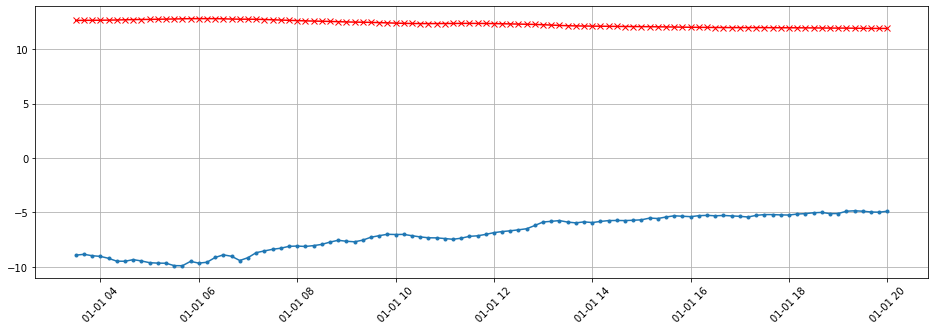

In [91]:
lmodel = TimeSeriesLSTM(history=20, nfeats=1, target_ahead=0,
                 UNITS1=32, UNITS2=0, npreds=1, verbose=0)

lmodel.model()
preload=0
if (preload):
    lmodel.load()
    lmodel.prepSet(prep)
else:
    prep=lmodel.prepare(dfn1,0, 300000)
    lmodel.save()
    
predictPlot_(0, 100, **vars(lmodel) )

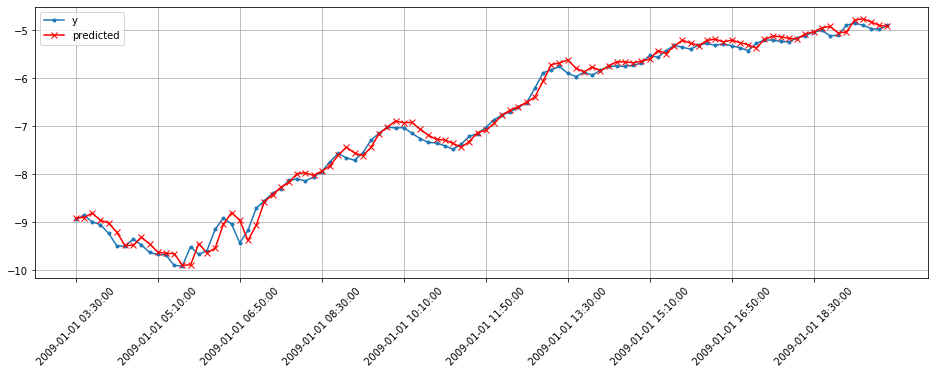

<Figure size 1152x360 with 0 Axes>

''

<Figure size 1152x360 with 0 Axes>

In [180]:
for i in range(5):
    display.clear_output(wait=True)
    plt.clf()
    predictPlot_(0, 100, **vars(lmodel) )
    plt.show()
    display.display(plt.gcf())
    lmodel.fit(1,0)
;

***
# MultiVariate Predictions

This uses multiple features dfn2 has 3 features we will use to train;
We will also predict temperature far ahead in the future say 12 hours ahead.

We will use 5 days of historical data with 3 features. Since temperature dont change often we down sample 
the entire data set to hours instead of 10 minutes

In [88]:
dfn3=dfn2[0:len(dfn2):6]
#dfn3

Training_split: 50000, target: T (degC)


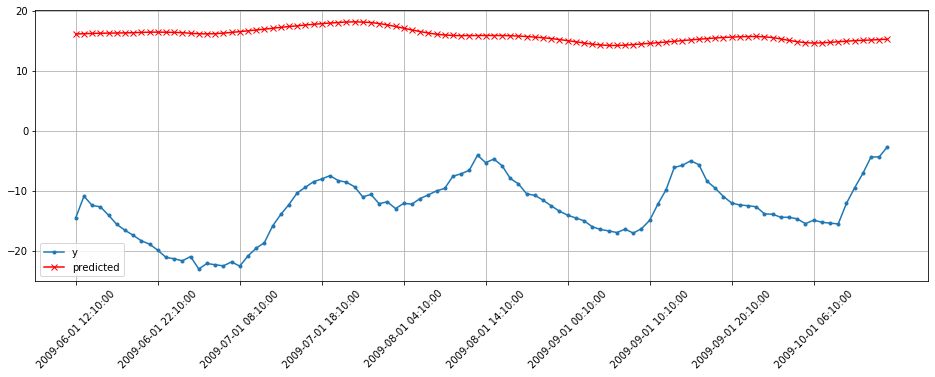

In [187]:
preload=0
lmodel1 = TimeSeriesLSTM(history=120, nfeats=3, target_ahead=12, UNITS1=32, UNITS2=0, npreds=1, verbose=0)
lmodel1.model()

if (preload == 1):
    lmodel1.load()
    lmodel1.prepSet(prep)
elif(preload == 0):
    prep=lmodel1.prepare(dfn3,0,50000)
    #lmodel1.save()
    
predictPlot_(0, 100, **vars(lmodel1) );


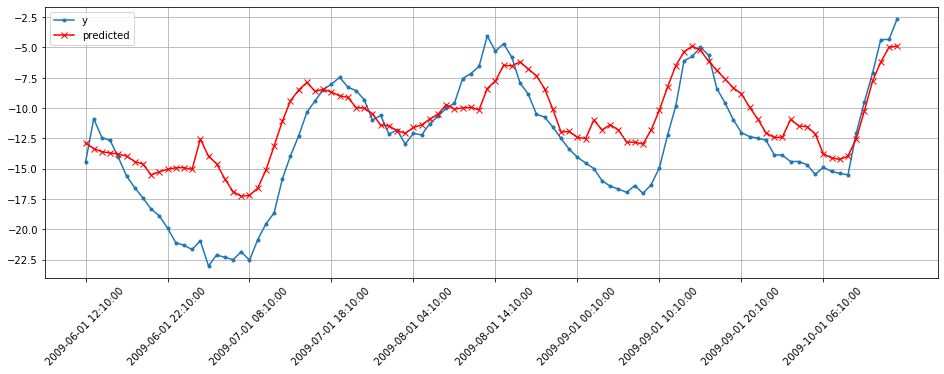

<Figure size 1152x360 with 0 Axes>

In [ ]:
for i in range(50):
    display.clear_output(wait=True)
    plt.clf()
    predictPlot_(0, 100, **vars(lmodel1) )
    plt.show()
    display.display(plt.gcf())
    lmodel1.fit(1,0)
;

120